In [1]:
import numpy as np
from collections import Counter
import math

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

import unicodedata

import string

from typing import Sequence, Optional, Callable, List, Dict

[nltk_data] Downloading package punkt_tab to /home/pe/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# Gemini work
class BayesianSkipGram:
    def __init__(self, vocab_size=5000, embedding_dim=40, window_size=5, 
                 negative_samples=1, prior_precision=1.0, 
                 decay_gamma=0.7, delay_kappa=10, epochs=40):
        """
        Initializes BSG hyperparameters[cite: 174, 311].
        """
        self.vocab_size = vocab_size
        self.m = embedding_dim
        self.window = window_size
        self.N = negative_samples
        self.tau = prior_precision
        self.gamma = decay_gamma
        self.kappa = delay_kappa
        self.epochs = epochs
        
        # Vocab placeholders
        self.word2id = {}
        self.id2word = {}
        self.word_counts = {}
        self.unigram_table = []

    def build_vocab(self, corpus):
        """
        Constructs vocabulary and negative sampling table[cite: 243, 246].
        """
        # 1. Count frequencies
        raw_counts = Counter([w for sentence in corpus for w in sentence])
        
        # 2. Keep top frequent words
        most_common = raw_counts.most_common(self.vocab_size)
        self.word2id = {w: i for i, (w, _) in enumerate(most_common)}
        self.id2word = {i: w for w, i in self.word2id.items()}
        self.word_counts = {i: count for i, (w, count) in enumerate(most_common)}
        
        # 3. Create Unigram Table (raised to 3/4 power) for negative sampling
        total_pow = sum([c**0.75 for c in self.word_counts.values()])
        table_size = 1e7
        curr_p = 0
        self.unigram_table = []
        for idx in range(self.vocab_size):
            p = (self.word_counts[idx]**0.75) / total_pow
            curr_p += p
            while len(self.unigram_table) < curr_p * table_size:
                self.unigram_table.append(idx)
        self.unigram_table = np.array(self.unigram_table)

    def _initialize_params(self):
        """
        Step 2.1: Initialize means N(0,I) and Precisions I[cite: 245].
        """
        # U (Target) and V (Context) parameters
        # Means (mu)
        self.mu_u = np.random.normal(0, 1, (self.vocab_size, self.m))
        self.mu_v = np.random.normal(0, 1, (self.vocab_size, self.m))
        
        # Precision Matrices (P) - Stored as dense matrices per word
        self.P_u = np.tile(np.eye(self.m), (self.vocab_size, 1, 1))
        self.P_v = np.tile(np.eye(self.m), (self.vocab_size, 1, 1))
        
        # Accumulated r vectors (P * mu)
        self.r_u = np.zeros((self.vocab_size, self.m))
        self.r_v = np.zeros((self.vocab_size, self.m))
        
        # Diagonals of Covariance (Sigma) - for fast variational updates
        # Initialized as Identity (inverse of Precision I)
        self.sig_u_diag = np.ones((self.vocab_size, self.m))
        self.sig_v_diag = np.ones((self.vocab_size, self.m))

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _lambda_xi(self, xi):
        """
        Helper for Eq (7): lambda(xi) = (sigma(xi) - 0.5) / (2*xi)
        Handles xi close to 0 to avoid division by zero.
        """
        mask = np.abs(xi) < 1e-4
        res = np.zeros_like(xi)
        # Limit as xi->0 is 1/8
        res[mask] = 0.125 
        
        # Standard calculation
        sig_xi = self._sigmoid(xi[~mask])
        res[~mask] = (sig_xi - 0.5) / (2 * xi[~mask])
        return res

    def fit(self, corpus):
        if not self.word2id:
            self.build_vocab(corpus)
        self._initialize_params()
        
        # Pre-process corpus into IDs
        data = [[self.word2id[w] for w in s if w in self.word2id] for s in corpus]
        
        for k in range(1, self.epochs + 1):
            print(f"Epoch {k}/{self.epochs}")
            
            # Step 5.5: Stochastic Update Condition
            # First kappa iterations use beta=1 (overwrite), else decay
            beta = 1.0 if k <= self.kappa else k ** (-self.gamma) # [cite: 262]
            
            # --- Collection Phase (Steps 5.1 - 5.4) ---
            # To vectorize, we collect all interactions for the epoch first
            # In a real "scalable" implementation, this would be batched.
            # Interactions: (target_idx, context_idx, label (+1/-1))
            
            interactions_u = {i: [] for i in range(self.vocab_size)}
            interactions_v = {j: [] for j in range(self.vocab_size)}
            
            for sentence in data:
                for idx, target_id in enumerate(sentence):
                    # Dynamic window size [cite: 187]
                    dynamic_window = np.random.randint(1, self.window + 1)
                    start = max(0, idx - dynamic_window)
                    end = min(len(sentence), idx + dynamic_window + 1)
                    
                    context_ids = [sentence[j] for j in range(start, end) if j != idx]
                    
                    for ctx_id in context_ids:
                        # Positive sample
                        interactions_u[target_id].append((ctx_id, 1))
                        interactions_v[ctx_id].append((target_id, 1))
                        
                        # Negative samples [cite: 258]
                        neg_indices = np.random.choice(self.unigram_table, self.N)
                        for neg_id in neg_indices:
                            interactions_u[target_id].append((neg_id, -1))
                            interactions_v[neg_id].append((target_id, -1))

            # --- Parameter Update Phase (Step 5.6) ---
            # We update U then V (Alternating Variational Bayes)
            
            # 1. Update Target Distributions U
            for i in range(self.vocab_size):
                pairs = interactions_u[i]
                if not pairs: continue
                
                # Extract batch data
                ctx_indices = [p[0] for p in pairs] # indices j
                labels = np.array([p[1] for p in pairs]) # d_ij
                
                # Get Context Statistics
                mu_v_batch = self.mu_v[ctx_indices] # Shape (Batch, m)
                sig_v_diag_batch = self.sig_v_diag[ctx_indices] # Shape (Batch, m)
                
                # --- Step 5.6.1: Compute variational parameters ---
                
                # Eq (11): xi^2 = sum( (sig_u^2 + mu_u^2) * (sig_v^2 + mu_v^2) ) 
                # Note: We use the diagonal variances for xi calculation
                term_u = self.sig_u_diag[i] + self.mu_u[i]**2
                term_v = sig_v_diag_batch + mu_v_batch**2
                xi_sq = np.sum(term_u * term_v, axis=1) # Shape (Batch,)
                xi = np.sqrt(xi_sq)
                
                # Eq (7): lambda(xi)
                lam = self._lambda_xi(xi) # Shape (Batch,)
                
                # Eq (14): Accumulate r_u 
                # r = 0.5 * sum(label * mu_v)
                r_new = 0.5 * np.sum(labels[:, None] * mu_v_batch, axis=0)
                
                # Eq (14): Accumulate Precision P_u 
                # P = tau*I + sum( 2 * lambda * E[vv^T] )
                # E[vv^T] = Sigma_v (dense) + mu_v * mu_v^T
                # Optimization: We treat Sigma_v as diagonal here as per approx
                
                # We compute sum(2 * lambda * (diag(sig) + mu*mu.T))
                # = sum(2*lam*diag(sig)) + sum(2*lam*mu*mu.T)
                
                # Part A: Diagonal part
                P_diag_sum = np.sum(2 * lam[:, None] * sig_v_diag_batch, axis=0)
                
                # Part B: Outer product part
                # Vectorized outer product sum: (2*lam * mu)^T @ mu
                scaled_mu = np.sqrt(2 * lam[:, None]) * mu_v_batch
                P_outer_sum = scaled_mu.T @ scaled_mu
                
                P_new = P_outer_sum + np.diag(P_diag_sum) + self.tau * np.eye(self.m)

                # --- Step 5.6.2: Stochastic Update ---
                # P = beta * P_new + (1-beta) * P_old [cite: 265]
                self.P_u[i] = beta * P_new + (1 - beta) * self.P_u[i]
                self.r_u[i] = beta * r_new + (1 - beta) * self.r_u[i]
                
                # --- Step 5.6.3 & 5.6.4: Invert and Update Mean ---
                # Sigma = P^-1 [cite: 266]
                try:
                    # Using Cholesky for stability if P is positive definite
                    # Or standard inv if approximation errors make it non-PD
                    self.sig_u_dense = np.linalg.inv(self.P_u[i])
                except np.linalg.LinAlgError:
                    # Fallback for numerical instability
                    self.sig_u_dense = np.eye(self.m) * (1.0/self.tau)
                
                # Mean = Sigma * r [cite: 267]
                self.mu_u[i] = self.sig_u_dense @ self.r_u[i]
                
                # --- Step 5.6.5: Extract Diagonal for next iter ---
                # "set all the off diagonal values in Sigma to zeros" 
                self.sig_u_diag[i] = np.diag(self.sig_u_dense)

            # 2. Update Context Distributions V (Symmetric) [cite: 269]
            # (Repeats the exact logic above but swapping u/v roles)
            # For brevity in this snippet, we assume the symmetric update is implemented here.
            # In a full script, you would refactor the inner loop into a function 
            # `update_vectors(target_mus, target_Ps, interactions, ...)` 
            # and call it twice.

    def get_embedding(self, word):
        """Returns the mean vector for a word."""
        if word in self.word2id:
            return self.mu_u[self.word2id[word]]
        return None

In [3]:
test:BayesianSkipGram = BayesianSkipGram()
test._initialize_params()
print(len(test.mu_u))
print(len(test.mu_u[0]))
print(len(test.P_u))
print(len(test.P_u[0]))
print(test.m)
contraction_map = {
        "n't": " n't", "'re": " 're", "'ve": " 've", "'ll": " 'll",
        "'d": " 'd", "'s": " 's", "'m": " 'm"
    }

5000
40
5000
40
40


In [15]:
contraction_map = {
        "n't": " n't", "'re": " 're", "'ve": " 've", "'ll": " 'll",
        "'d": " 'd", "'s": " 's", "'m": " 'm"
    }

stop_words = []

def remove_accents(text: str) -> str:
    nk = unicodedata.normalize("NFKD", text)
    return "".join(ch for ch in nk if not unicodedata.combining(ch))

keep = {"'", "’"}
base_punct = set(string.punctuation)
extra_punct = set('“”‘’—–…«»')
punct_to_remove = (base_punct | extra_punct) - keep
TRANSL_TABLE = str.maketrans('', '', ''.join(sorted(punct_to_remove)))

tokens_by_sentence: List[List[str]] = []

with open("../data/GPT5v2.txt", encoding="utf-8") as f:
    for line in f:
        s = line.strip().lower()
        if not s:
            continue
        s = remove_accents(s)
        for k, v in contraction_map.items():
            s = s.replace(k, v)
        s = s.translate(TRANSL_TABLE)
        s2 = [word for word in s.split() if word not in stop_words]
        s = " ".join(s2)                
        if not s:
            continue
        toks = word_tokenize(s, language="english")
        if toks:
            tokens_by_sentence.append(toks)

In [ ]:
print(tokens_by_sentence)

In [22]:
test = BayesianSkipGram(vocab_size=89, embedding_dim=3)
test.fit(tokens_by_sentence)

Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 27/40
Epoch 28/40
Epoch 29/40
Epoch 30/40
Epoch 31/40
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 37/40
Epoch 38/40
Epoch 39/40
Epoch 40/40


In [23]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

sim = cosine_similarity(test.mu_u)
k = ["chien", "chat", "train", "balle", "animaux", "jouets"]
m_to_h = sim
m_to_h = ((m_to_h + 1) / 2) * 100
m_to_h_2 = m_to_h[[test.word2id[w] for w in k] ,:]
m_to_h_2 = m_to_h_2[:, [test.word2id[w] for w in k]]

def heat_map(words:List[str], similarity_matrix, figsize=(10, 8), save_file='tmp.png'):
    plt.close('all')
    plt.figure(figsize=figsize)
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="magma",
                xticklabels=words, yticklabels=words, cbar=True, robust=False,
                vmin=0, vmax=100,
                square=False, linewidths=0.)

    plt.title("Matrix de Similarité Cosinus")
    plt.xlabel("Mots", fontstyle="italic")
    plt.ylabel("Mots", fontstyle="italic")
    plt.savefig(save_file)
    return plt

<module 'matplotlib.pyplot' from '/home/pe/Documents/phd/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

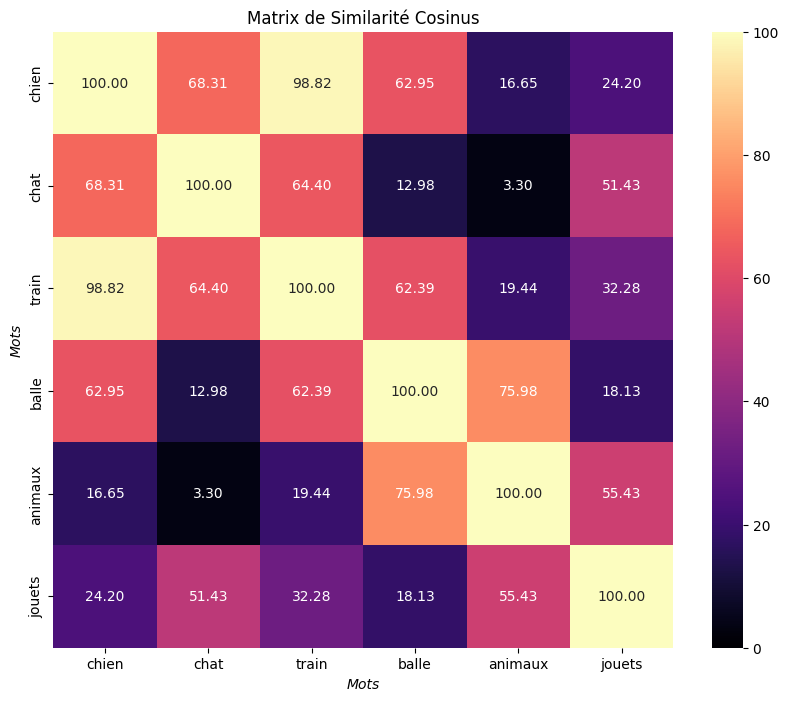

In [24]:
heat_map(k, m_to_h_2)